In [12]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from collections import defaultdict
import random

## Data Normalization
### Normalize Data with achieved mean and sd

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
binary_class_names = ['Not Flipped', 'Flipped']

100%|██████████| 170498071/170498071 [00:03<00:00, 47889609.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Data Labeling

In [7]:
class BalancedFlipCIFAR10(Dataset):
    def __init__(self, cifar_dataset):
        self.cifar_dataset = cifar_dataset
        self.flip_labels = torch.randint(0, 2, (len(cifar_dataset),))

    def __len__(self):
        return len(self.cifar_dataset)

    def __getitem__(self, idx):
        image, original_label = self.cifar_dataset[idx]
        flip_label = self.flip_labels[idx]
        if flip_label == 1:
            image = transforms.functional.vflip(image)
        return image, flip_label, original_label

### Data Loading

In [19]:
balanced_train_dataset = BalancedFlipCIFAR10(trainset)
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)

balanced_test_dataset = BalancedFlipCIFAR10(testset)
test_loader = DataLoader(balanced_test_dataset, batch_size=64, shuffle=False)

# Model 2: VGG16

## Model Setup

In [13]:
model_vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
for param in model_vgg16.features.parameters():
    param.requires_grad = False
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_features, 1)

In [14]:
criterion_vgg16 = nn.BCEWithLogitsLoss()
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)

## Training Function

In [20]:
def train_model(model, criterion, optimizer, train_dataset, num_epochs=10):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, flip_labels, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, flip_labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')
    print('Finished Training')


In [22]:
train_model(model_vgg16, criterion_vgg16, optimizer_vgg16, balanced_train_dataset, num_epochs=10)

Epoch 1, Loss: 0.6305108139353335
Epoch 2, Loss: 0.5584006950907086
Epoch 3, Loss: 0.5203515417740473
Epoch 4, Loss: 0.4963480742157573
Epoch 5, Loss: 0.4774317616391975
Epoch 6, Loss: 0.462666368278701
Epoch 7, Loss: 0.447007948404078
Epoch 8, Loss: 0.43210782991041
Epoch 9, Loss: 0.4219830910987256
Epoch 10, Loss: 0.4080733441559555
Finished Training


## Save training result

In [23]:
PATH_VGG16 = './cifar_vgg16.pth'
torch.save(model_vgg16.state_dict(), PATH_VGG16)

In [24]:
model_vgg16.load_state_dict(torch.load(PATH_VGG16))
model_vgg16.eval()

correct = 0
total = 0
test_loader = DataLoader(balanced_test_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    for images, flip_labels, original_labels in test_loader:
        outputs = model_vgg16(images)
        predicted = torch.round(torch.sigmoid(outputs)).squeeze()
        total += flip_labels.size(0)
        correct += (predicted == flip_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test images: {accuracy:.2f}%')

Accuracy on the test images: 76.35%


In [25]:
from sklearn.metrics import classification_report
import torch
import numpy as np

true_labels = []
predictions = []

model_vgg16.eval()
with torch.no_grad():
    for images, flip_labels, original_labels in test_loader:
        outputs = model_vgg16(images)
        predicted = torch.round(torch.sigmoid(outputs)).squeeze()
        true_labels.extend(flip_labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

print(classification_report(true_labels, predictions, target_names=binary_class_names))



              precision    recall  f1-score   support

 Not Flipped       0.78      0.73      0.75      4951
     Flipped       0.75      0.79      0.77      5049

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [26]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
binary_class_names = ['Not Flipped', 'Flipped']

correct_predictions = {label: 0 for label in range(len(class_names))}
total_predictions = {label: 0 for label in range(len(class_names))}

misclassified_info = []

with torch.no_grad():
    for images, flip_labels, original_labels in test_loader:
        outputs = model_vgg16(images)
        predicted = torch.round(torch.sigmoid(outputs)).squeeze()

        for i in range(images.size(0)):
            total_predictions[original_labels[i].item()] += 1
            if predicted[i] == flip_labels[i]:
                correct_predictions[original_labels[i].item()] += 1
            else:
                misclassified_info.append((images[i], flip_labels[i], predicted[i], original_labels[i]))

class_accuracy = {class_name: correct_predictions[i] / total_predictions[i] for i, class_name in enumerate(class_names)}

lowest_accuracy_classes = sorted(class_accuracy, key=class_accuracy.get)[:3]

print("Classes with the lowest accuracy in detecting flipped/not flipped:")
for class_name in lowest_accuracy_classes:
    print(f"{class_name}: {class_accuracy[class_name]:.2%}")


Classes with the lowest accuracy in detecting flipped/not flipped:
cat: 63.10%
frog: 63.40%
deer: 69.10%


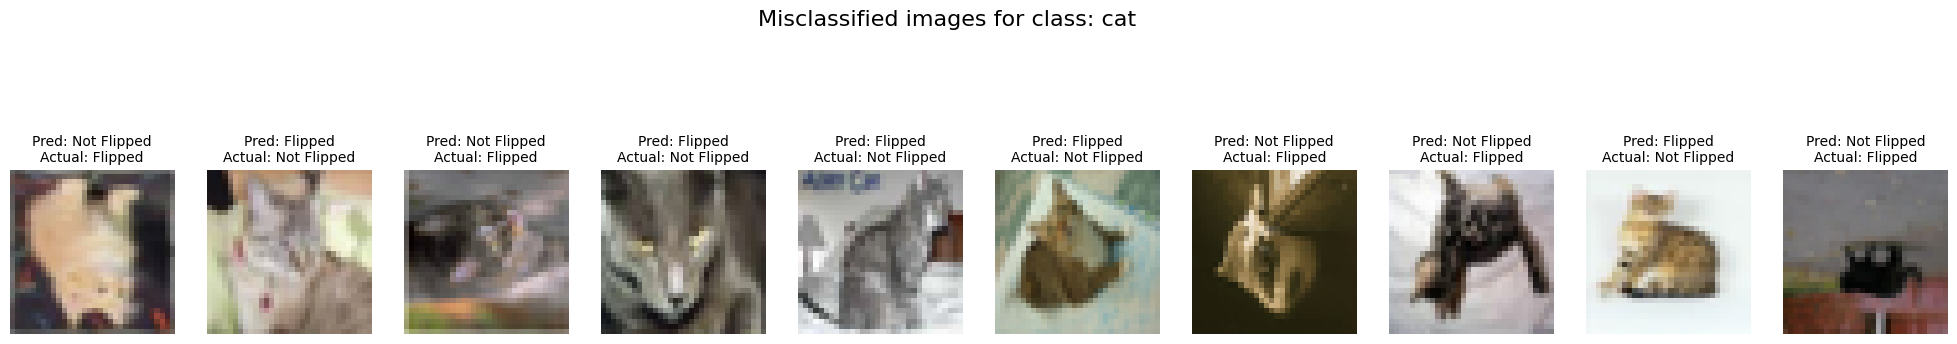

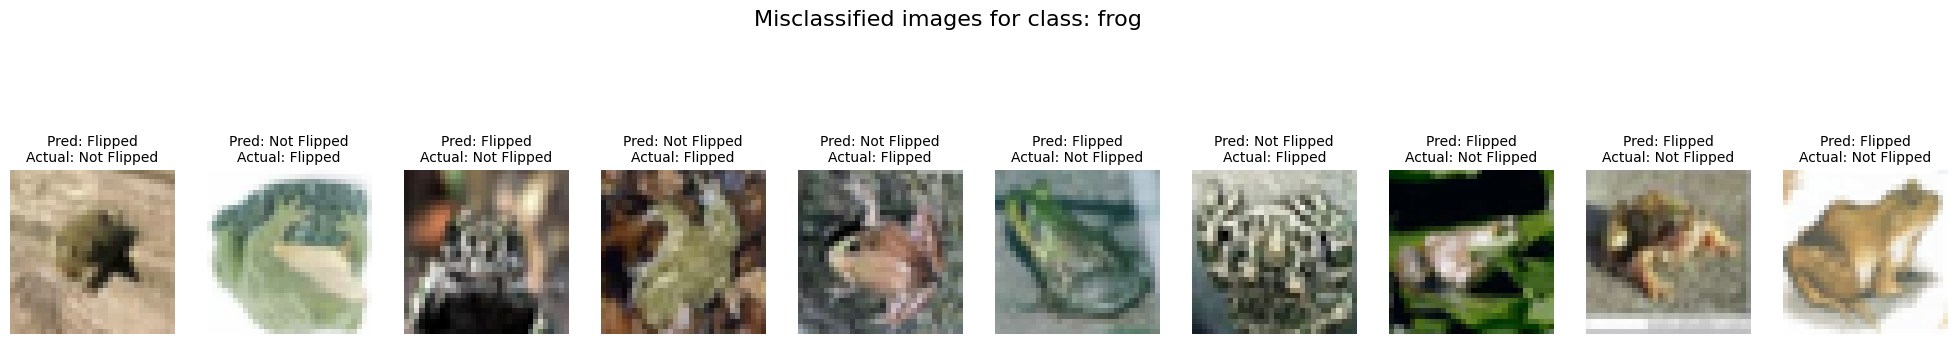

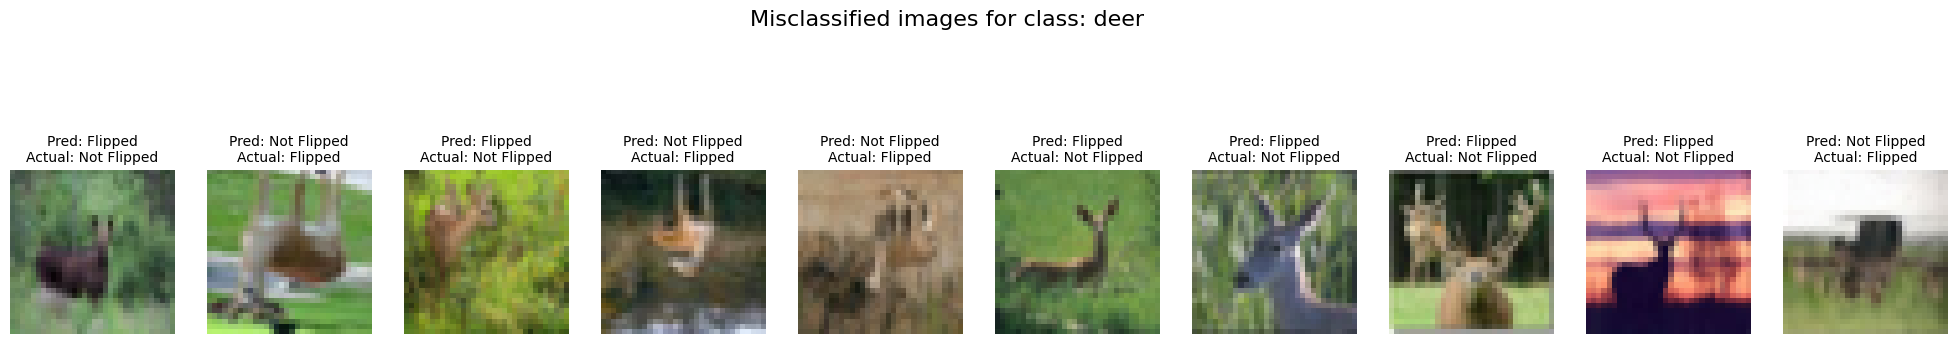

In [27]:
import random
from collections import defaultdict

def imshow(img):
    '''Display an image.'''
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Filtered misclassified_info only for the above lowest accuracy classes
lowest_accuracy_class_indices = [class_names.index(class_name) for class_name in lowest_accuracy_classes]
filtered_misclassified_info = [info for info in misclassified_info if info[3].item() in lowest_accuracy_class_indices]

# Group misclassified images by class
misclassified_by_class = defaultdict(list)
for image, flip_status, pred_label, true_label in filtered_misclassified_info:
    misclassified_by_class[true_label.item()].append((image, flip_status, pred_label))

# Display up to 10 misclassified images for 3 classes
for class_idx in lowest_accuracy_class_indices:
    misclassified_images = misclassified_by_class[class_idx]

    # Randomly select up to 10 images from the misclassified images of this class
    selected_images = random.sample(misclassified_images, min(10, len(misclassified_images)))

    # Setting up the plot
    fig = plt.figure(figsize=(25, 5))
    plt.suptitle(f'Misclassified images for class: {class_names[class_idx]}', fontsize=16)

    for i, (image, flip_status, pred_label) in enumerate(selected_images, start=1):
        ax = fig.add_subplot(1, len(selected_images), i)  # Adjust subplot count based on the actual number of images
        imshow(image)
        ax.set_title(f'Pred: {"Flipped" if pred_label.item() == 1 else "Not Flipped"}\nActual: {"Flipped" if flip_status.item() == 1 else "Not Flipped"}', fontsize=10)
    plt.show()